# Recommender Systems with PySpark

Inspired by this common Spark [tutorial](https://github.com/jadianes/spark-movie-lens/blob/master/notebooks/building-recommender.ipynb) but updated to work with dataframes.

We will be using MovieLens data to create a recommender system with PySpark.

In [9]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests, os, sys, zipfile, io

# pyspark imports
import pyspark

warnings.filterwarnings('ignore')
pd.options.display.mpl_style = 'default'

%matplotlib inline

## Connect to the Spark server

This is the standard spark session.

In [10]:
spark = pyspark.sql.SparkSession.builder.getOrCreate() 

We will also need access to the SQL context for one of the commands run in this notebook. Note that a spark cluster **CAN NOT** have more than one spark context running. If an error is produced, try skipping this cell. If that does not work, the running container must be stopped (`docker stop _container_id_`) and removed (`docker rm _container_id_`) and then a new container launched from the image with `docker run`.

In [2]:
sc = pyspark.SparkContext()
sqlc = pyspark.sql.SQLContext(sc)

## Obtain the data

We begin by downloading the smaller movie ratings data set and writing it to a directory. If the larger dataset is desired, use the alternative value for `filepath`.

In [3]:
filepath = 'ml-latest-small'  # the smaller dataset
# filepath = 'ml-latest'      # the full dataset

url = 'http://files.grouplens.org/datasets/movielens/{}.zip'.format(filepath)

filename = 'movies.csv'
fullpath = os.sep.join([filepath, filename])

if not os.path.exists(fullpath):    
    sess = requests.session()
    resp = sess.get(url)
    zipdata = zipfile.ZipFile(io.BytesIO(resp.content))
    zipdata.extractall()

Preview the files from the downloaded data.

In [4]:
# first lines of included files
! head -n 3 {filepath}/movies.csv

In [5]:
! head -n 3 {filepath}/ratings.csv

In [6]:
! head -n 3 {filepath}/links.csv

In [7]:
! head -n 3 {filepath}/tags.csv

## Load the ratings

We begin by loading the ratings data.

In [11]:
ratings_path = os.sep.join([filepath, 'ratings.csv'])
ratings = spark.read.csv(ratings_path,
                        sep=',',
                        inferSchema=True,
                        header=True)

for column in ['userId','movieId','timestamp']:
    ratings = ratings.withColumn(column, ratings[column].cast('int'))
    
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [12]:
# function to select a few rows of data and convert to a Pandas dataframe
def preview(df, n=3):
    return pd.DataFrame(df.take(n), columns=df.columns)

We can preview the data as before.

In [13]:
preview(ratings)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


## Split data

Let's split the data into train and test data sets.

In [14]:
train, test = ratings.randomSplit([0.7, 0.3], seed=42)

## Build the recommender

Let's build our first reocmmendation system using PySpark's alternative least squares (ALS) matrix factorization. We will begin by using rank 4 matrices in the factorization. The rank (as well as many other factors), can be updated later using a grid search.

In [15]:
from pyspark.ml.recommendation import ALS

# create the model
als = ALS(userCol='userId',
          itemCol='movieId',
          ratingCol='rating',
          rank=4,
          seed=42)

# fit the model
als_model = als.fit(train)

# make predictions on the test set
als_pred = als_model.transform(test)

preview(als_pred[['userId', 'movieId', 'rating', 'prediction']])

,userId,movieId,rating,prediction
0,575,148,4.0,NaN
1,534,463,4.0,3.803605
2,350,471,3.0,3.799537


Let's calculate the error metric on this model. Since rating is a continuous value, it probably makes sense to use something like RMSE.

Let's begin by calculating the difference between the rating and prediction and then squaring it.

In [16]:
als_pred = als_pred.withColumn('diff_sq', (als_pred['rating'] - als_pred['prediction'])**2)

preview(als_pred[['rating','prediction','diff_sq']])

,rating,prediction,diff_sq
0,4.0,NaN,NaN
1,4.0,3.803605,0.038571
2,3.0,3.799537,0.639259


We can then calculate the RMSE over the entire data set using functions found in PySpark's SQL context (`pyspark.sql.functions`). In general, PySpark's functions **DO NOT** ignore NaN's, so we will have to drop them before doing the calculation otherwise it will return NaN.

In [17]:
from pyspark.sql import functions as func

# the aggregate function can be created outside of the dataframe if desired
rms_calc = func.sqrt(func.mean('diff_sq'))


# the aggregate function is then called using select
# this is similar syntax-wise to a SQL select
# and `alias` is used to set the column name
# note that a list of aggregate functions can be passed as well,
# which will return mulitple columns
als_pred.dropna().select( rms_calc.alias('rmse') ).show()

+-----------------+
|             rmse|
+-----------------+
|0.922772624896502|
+-----------------+



## Optimization with grid search

We can use a parameter grid to identify the best ALS model, much like we did with the supervised machine learning model. We will use RMSE as our error metric again, but we can simplify things by using the RMSE function from the `RegressionEvaluator` module.

See the note in the code about shortening the grid search time if it takes too long on your system.

In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# The ALS instance
als = ALS(userCol='userId',
          itemCol='movieId',
          ratingCol='rating',
          seed=42)

# The parameter grid to search
# NOTE: the parmeter lists can be reduced to two or even 
# one item if the grid search takes too long
als_paramgrid = (ParamGridBuilder()
                 .addGrid(als.rank, [2, 4])
                 .addGrid(als.maxIter, [10])
                 .addGrid(als.regParam, [0.1])
                 .addGrid(als.alpha, [2.0, 3.0])
                 .build())

# The evaluation function for determining the best model
rmse_eval = RegressionEvaluator(labelCol='rating',
                                predictionCol='prediction', 
                                metricName='rmse')

# The cross validation instance
als_cv = CrossValidator(estimator=als,
                        estimatorParamMaps=als_paramgrid,
                        evaluator=rmse_eval,
                        numFolds=3, 
                        seed=42)

# Fit the models and find the best one!
als_cv = als_cv.fit(train.dropna())

As we did with the supervised machine learning cross-validated model, we can explore the best cross-validated ALS model to a limited extent.

In [19]:
als_best = als_cv.bestModel

print(als_best.rank)

2


Now we can make predictions using the best model and calculate the RMSE. Based on the gridsearch, the RMSE was reduced slightly from 0.935 to 0.928.

In [21]:
als_pred_best = als_best.transform(test)

als_best_rmse = sqlc.createDataFrame([ (rmse_eval.evaluate(als_pred.dropna()), 
                                        rmse_eval.evaluate(als_pred_best.dropna())) ],
                                     ['rmse_original', 'rmse_crossval'])

als_best_rmse.show()

+------------------+-----------------+
|     rmse_original|    rmse_crossval|
+------------------+-----------------+
|0.9227726248965021|0.922972186762033|
+------------------+-----------------+



## Visualize predicted vs actual ratings

We can use a scatter plot to visualize how well our predictions for the test data match the actual ones.  As can be seen below, there is some room for improvement in our model!

In [22]:
# convert to a Pandas dataframe for plotting
als_pred_best_df = als_pred_best.dropna().toPandas()

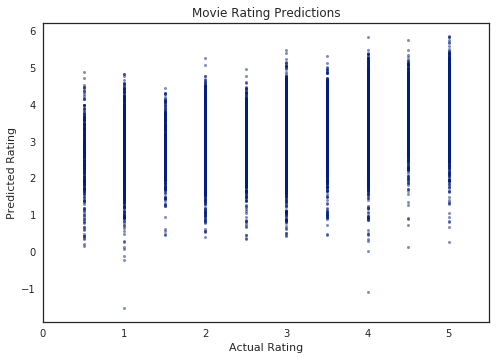

In [23]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = als_pred_best_df.plot('rating','prediction', 
                           marker='o', ls='', ms=3.0,
                           alpha=0.5, legend=False)

_ = ax.set(xlabel='Actual Rating', ylabel='Predicted Rating',
           title='Movie Rating Predictions')
ax.set_xlim(0, 5.5)

# save the figure in notebooks folder so it's accessible on AWS
fig = plt.gcf()
fig.savefig('movie_rating_predictions.pdf')

## Save recommendation model for later use

As with the gradient boosted tree model (GBT) in the supervised machine learning notebook, we can save our alternating least squares (ALS) model and load/use it elsewhere.

This section is essentially identical to the supervised machine learning example from yesterday.

In [24]:
model_output_name = 'als_recommendation_model_pipeline_crossval'

# models will not overwrite existing ones of the same name
import shutil
if os.path.exists(model_output_name):
    shutil.rmtree(model_output_name)
    
als_best.save(model_output_name)

! ls {model_output_name}

itemFactors  metadata  userFactors


Reloading is also similar--here we have to import the ALS model class.

In [25]:
from pyspark.ml.recommendation import ALSModel

reloaded_model = ALSModel.load(model_output_name)
reloaded_model

ALS_4121ada2091e1e1656fa